# HW4 Problem 1 
https://eee.uci.edu/16s/48480/home/Homework+4.pdf

In [1]:
using TensorOperations
using PyPlot

In [2]:
function creatA(n)
    A = [zeros(1,2,1) for i=1:n];

    for i=1:n
    A[i][1,iseven(i) ? 2 : 1,1] = 1.0
    end
    A
end
A = creatA(10);
@show n = size(A,1);

n = size(A,1) = 10


In [3]:
reshape(A[1][1,:,:],2,1)' *reshape(A[1][1,:,:],2,1)

1x1 Array{Float64,2}:
 1.0

### part a using for loop

In [4]:
function normsq1(A)
    B=zeros(1)
    C = A[1]
    # @show A[1]
    # @show C
    for x=1:n-1
        for i=1:1, j=1:2, k1=1:1, k2=1:1
            B[k1,k2] += C[i,j,k1] * A[x][i,j,k2]
        end
    #     @show C[1,:,1]
        C = zeros(1,2,1)
    #     @show C[1,:,1]

        for i=1:1, j=1:2, k1=1:1, k2=1:1
            C[k1,j,k2] += B[k1,i] *A[x+1][i,j,k2]
        end
        B=zeros(1)
    end
    answer = 0
    for i=1:1, j=1:2, k=1:1
        answer += C[i,j,k] * A[n][i,j,k]
    end
    answer
end
@time normsq1(A)

  0.070567 seconds (54.13 k allocations: 2.395 MB)


1.0

### part b using Matrix product

In [5]:
## test to learn how it works
temp = reshape(A[1],2,1)
B = temp' * temp
C = B * reshape(A[2],1,2)
reshape(C,2,1)' * reshape(A[2],2,1)

1x1 Array{Float64,2}:
 1.0

In [6]:
function normsq2(A)
    n = size(A,1)
    C=A[1]
    for x=1:n-1
#         B = reshape(C,2,1)' * reshape(A[x],2,1)
#         C = B * reshape(A[x+1],1,2)
        C = reshape(C,2,1)' * reshape(A[x],2,1) * reshape(A[x+1],1,2)
    end
    answer = reshape(C,2)' * reshape(A[n],2)
    answer[1]
end
@time normsq2(A)
    

  0.064868 seconds (36.63 k allocations: 1.723 MB)


1.0

### part c using TensorOperations

In [7]:
function normsq3(A)
    n = size(A,1)
    C = A[1]
    A2 = zeros(A[1])
    A1 = zeros(A[1])
    for x=1:n-1
        A2 = A[x+1]
#         @show A2
        A1 = A[x]
#         @show A1
        @tensor begin
            C[i,j,k] := A1[ip,jp,i] * C[ip,jp,kp] * A2[kp,j,k]
        end
    end
#     An = A
    @tensor begin
        answer = scalar(C[i,j,k] * A2[i,j,k])
        end
    answer
end
@time normsq3(A)

  1.957081 seconds (1.72 M allocations: 74.937 MB, 1.77% gc time)


1.0

# Problem 2 moving orthogonality center

In [8]:
type MPS
A
oc::Int64
end

In [9]:
function moveto!(psi::MPS, i::Int64)
    oc = psi.oc
    oc==i && return psi
    A = psi.A
    if i> oc
        for x=oc:i-1
            m1, d, m2 = size(A[x])
            m2t, dt, m3 = size(A[x+1])
            (m2 !=m2t || d!= dt ) && return "error mismatch dimension in moveto! right"
            Q, R=qr(reshape(A[x],d * m1, m2))    ##
            A[x] = reshape(Q, m1, d, m2)
            A[x+1] = reshape(R* reshape(A[x+1], m2, d*m3), m2, d, m3)
            psi.oc = x+1
        end
    else
        for x=oc:-1:i+1
            m1, d, m2 = size(A[x-1])
            m2t, dt, m3 = size(A[x])
            (m2 !=m2t || d!= dt ) && return "error mismatch dimension in moveto! left"
            Q, R=qr(reshape(A[x], m2, d*m3)')
            A[x] = reshape(Q', m2, d, m3)
            A[x-1] = reshape(reshape(A[x-1],d*m1 ,m2) * R', m1, d, m2)
            psi.oc = x-1
        end
            
    end
    psi.A = A
    psi
end
psi=MPS(deepcopy(A),5);
moveto!(psi,7)
@show psi.oc
@show psi.A[5:9]
@show normsq3(psi.A) ## testing the norm that shouldn't change
moveto!(psi,2)
@show psi.oc
@show psi.A[5:-1:1]
@show normsq3(psi.A) ## testing the norm that shouldn't change

psi.oc = 7
psi.A[5:9] = [
[1.0 0.0],

[0.0 -1.0],

[-1.0 0.0],

[0.0 1.0],

[1.0 0.0]]
normsq3(psi.A) = 1.0
psi.oc = 2
psi.A[5:-1:1] = [
[1.0 0.0],

[0.0 1.0],

[1.0 0.0],

[0.0 -1.0],

[1.0 0.0]]
normsq3(psi.A) = 1.0


1.0

## Problem 3 energy bond function

In [10]:
sz = Float64[0.5 0; 0 -0.5] ; sp = Float64[0 1; 0 0] ; sm = sp'
Htwosite = Float64[sz[s1,s1p] * sz[s2,s2p] + 0.5 * (sp[s1,s1p] * sm[s2,s2p] +
sm[s1,s1p] * sp[s2,s2p]) for s1=1:2, s2=1:2, s1p=1:2, s2p=1:2]
## this is the same as doing kron 
h_test = 0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz)
reshape(h_test,2,2,2,2)==Htwosite

true

In [11]:
Htwosite[1,]

0.25

In [12]:
# psi=MPS(deepcopy(A), 4);
A = creatA(5)
psi=MPS(A, 1);
function energybond(psi::MPS, i::Int64)
    moveto!(psi,i)
    Ai = psi.A[i]
    Ai1 = psi.A[i+1]
    H = Htwosite
#     @show H
    @tensor begin
        answer[] := Ai[i1,k,i2] * Ai1[i2,k1,i3]* H[k, k1, kp, k1p] * Ai[i1, kp, i2p] * Ai1[i2p,k1p,i3]
        Norm =  scalar(Ai[i1,k,i2] * Ai1[i2,k1,i3] * Ai[i1, k, i2p] * Ai1[i2p,k1,i3])
    end
#     assert(Norm > 0.9)
#     return answer[1]
    answer[1] / Norm[1]
#     @show Norm
end
@show energybond(psi,1)
@show A
normsq3(A)

energybond(psi,1) = -0.25
A = [
[1.0 0.0],

[0.0 1.0],

[1.0 0.0],

[0.0 1.0],

[1.0 0.0]]


1.0

In [13]:
A1 = creatA(5)
B1 = creatA(5)
B1[5][1,1,1] =0
B1[5][1,2,1] =1
# @show B1
# @show A1
C = A1[1]
# A2 = zeros(A[1])
# A1 = zeros(A[1])
n=5
for x=1:n-1
    Ax1 = A1[x+1]
#         @show Ax1
    Bx = B1[x]
#         @show Bx
    @tensor begin
        C[i,j,k] := Bx[ip,jp,i] * C[ip,jp,kp] * Ax1[kp,j,k]
    end
#     @show C
end
Bx = B1[n]
# @show Bx
@tensor begin
    answer = scalar(C[i,j,k] * Bx[i,j,k])
    end
answer




0.0

Test to see how does one site operator works 

In [14]:
@show sx = .5(sp +sm)
@show A_at5 = A1[5]
@show B_at5 = B1[5]
@show B1[5]
@tensor begin
    test[i,k,j] := sx[k,kp] * B_at5[i,kp,j]
    answer = scalar(A_at5[i,k,j]* sz[k , kp] * A_at5[i,kp,j])
end
@show test
answer

sx = 0.5 * (sp + sm) = [0.0 0.5
 0.5 0.0]
A_at5 = A1[5] = [1.0 0.0]
B_at5 = B1[5] = [0.0 1.0]
B1[5] = [0.0 1.0]


LoadError: LoadError: TensorOperations.IndexError{ASCIIString}("invalid number of indices: ()")
while loading In[14], in expression starting on line 7

## Problem 4 TEBD

Initializing energy at Neel state -0.25
 Energy per site forward sweep 500 = -0.41451665102535107
 Energy per site backward sweep 500 = -0.4145511135284071
 Energy per site forward sweep 1000 = -0.4295472667221148
 Energy per site backward sweep 1000 = -0.42955319496779104
 Energy per site forward sweep 1500 = -0.4330210300850453
 Energy per site backward sweep 1500 = -0.433023006719828
 Energy per site forward sweep 2000 = -0.4343703536375754
 Energy per site backward sweep 2000 = -0.43437126539293675
 Energy per site forward sweep 2500 = -0.43505580280115386
 Energy per site backward sweep 2500 = -0.4350563187608221
 Energy per site forward sweep 3000 = -0.43547294665877084
 Energy per site backward sweep 3000 = -0.43547328600393675
 Energy per site forward sweep 3500 = -0.43576215439576654
 Energy per site backward sweep 3500 = -0.43576240210841843
 Energy per site forward sweep 4000 = -0.4359802164032772
 Energy per site backward sweep 4000 = -0.4359804086681958
 Energy per site fo

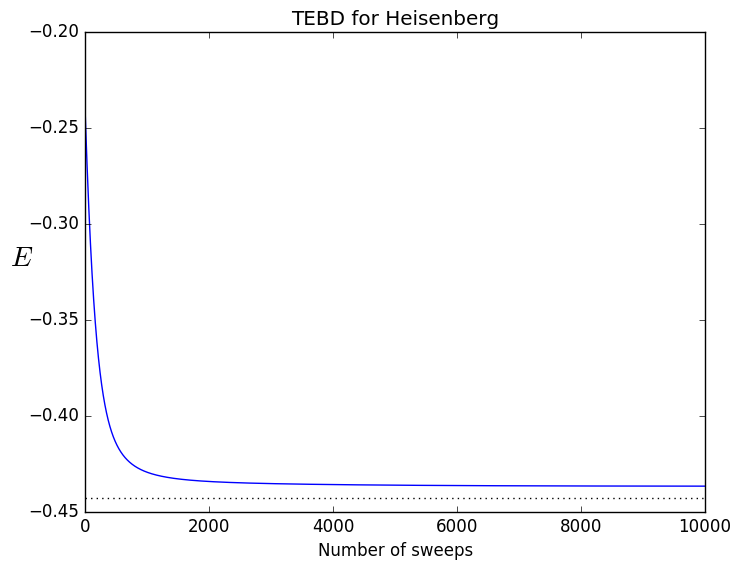

PyObject <matplotlib.lines.Line2D object at 0x7f8680e0cba8>

In [15]:
function dosvdtoright(AA, m)
    m1= size(AA, 1)     ## find the size of first dimension 
    m2= size(AA, 4)     ## find the size of forth dimension 
    d = size(AA, 2)      ## find size of physical index
    F = svdfact(reshape(AA, d * m1, d * m2)) 
    x = m1 <m2 ? m1*d : m2*d   ## choosing the smaller one since we are using the thin format of SVD
    x = x<m ? x : m ## truncation to m state
    A = reshape(F[:U][:, 1:x] , m1, d, x)
    A1 = reshape(diagm(F[:S][1:x]) * F[:Vt][1:x ,:], x, d, m2)
    return  (A, A1)
#     return (reshape(F[:U], m1, d, x) , reshape(diagm(F[:S])*F[:Vt], x, d, m2))
#     U[:,1:m]*diagm(S[1:m])*V'[1:m,:],
end

function dosvdtoleft(AA, m)
    m1= size(AA, 1)     ## find the size of first dimension 
    m2= size(AA, 4)     ## find the size of forth dimension 
    d = size(AA, 2)      ## find size of physical index
    F = svdfact(reshape(AA, d * m1, d * m2)) 
    x = m1 <m2 ? m1*d : m2*d  ## choosing the smaller one since we are using the thin format of SVD
    x = x<m ? x : m ## truncation to m state
    A = reshape(F[:U][:, 1:x]*  diagm(F[:S][1:x]) , m1, d, x)
    A1 = reshape(F[:Vt][1:x ,:], x, d, m2)
    return  (A, A1)
end

function sweep(psi, Num_sweeps, m)
    E_per_N = []
    N = size(psi.A,1)
    for x=1:Num_sweeps
        Energy = 0.0
        for i=1:N-1
            Energy += energybond(psi, i)
            Ai = psi.A[i]
            Ai1 = psi.A[i+1]
            @tensor begin
                AA[a,f,g,e] := Ai[a,b,c] * Ai1[c,d,e] * taugate[b,d,f,g]
                norm = scalar(AA[a,f,g,e] * AA[a,f,g,e])
                AA /= norm
            end
            (psi.A[i],psi.A[i+1]) = dosvdtoright(AA,m)
  
            psi.oc = i+1
        end
#         x%500 ==1 && println(" Norm = $(normsq3(psi.A))")
        x%500 ==0 && println(" Energy per site forward sweep $x = $(Energy/N)")
        Energy = 0.0
        
        for i=N-1:-1:1
            Energy += energybond(psi, i)
            Ai = psi.A[i]
            Ai1 = psi.A[i+1]
            @tensor begin
                AA[a,f,g,e] := Ai[a,b,c] * Ai1[c,d,e] * taugate[b,d,f,g]
                norm = scalar(AA[a,f,g,e] * AA[a,f,g,e])
                AA /= norm
            end
            (psi.A[i],psi.A[i+1]) = dosvdtoleft(AA,m)
            psi.oc = i
        end
        push!(E_per_N, Energy/N)
        x%500 ==0 && println(" Energy per site backward sweep $x = $(Energy/N)")
        
#         x%500 ==1 && println("E_middle full sweep $x =  $(energybond(psi, Int64(N/2)))") 
    end
    return (E_per_N, psi)
end
const N = 30
A = creatA(N)
psi=MPS(A, 2);
tau = 0.001
taugate = reshape(expm(- tau * reshape(Htwosite,4,4)),2,2,2,2);

println("Initializing energy at Neel state $(energybond(psi, Int64(N/2)))")

Num_sweeps = 10000
Max_State = 15
En , psi = sweep(psi, Num_sweeps, Max_State);

@show psi.oc

plot(1:Num_sweeps, En, "b")
title("TEBD for Heisenberg")
xlabel("Number of sweeps")
ylabel(L"$E$", rotation=0, fontsize = 20)
plt[:axhline](1/4-log(2),c="k", ls=":")


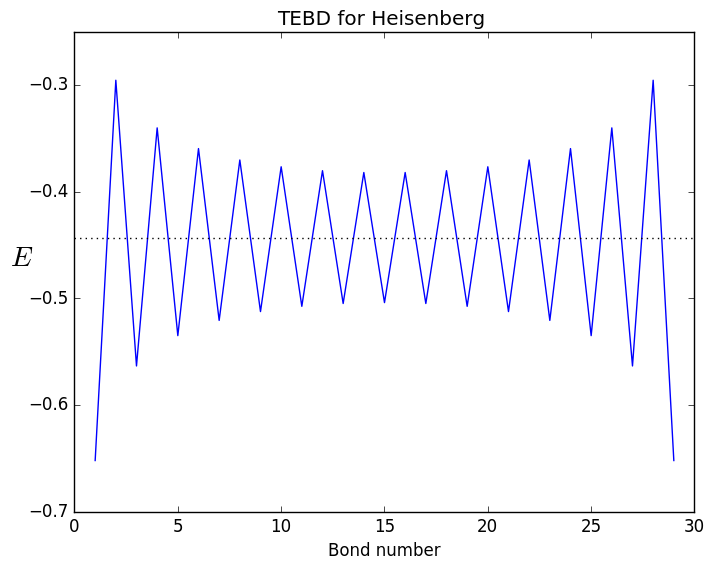

In [18]:
## plotting bound energy for every sites
Num_Bonds = size(psi.A)[1]-1
E_bonds = zeros(Num_Bonds)
for i=1:Num_Bonds
    E_bonds[i] = energybond(psi, i)
end
plot(1:Num_Bonds, E_bonds)
title("TEBD for Heisenberg ")
xlabel("Bond number")
ylabel(L"$E$", rotation=0, fontsize = 20)
plt[:axhline](1/4-log(2),c="k", ls=":");   ### Bethe anzats

In [17]:
A1 = zeros(3,2)
for i=1:5
    A1 = ones(5,4)
end
A1

5x4 Array{Float64,2}:
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0